In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
SOURCE_PATH = 'Dataset/genres_original/'
JSON_PATH = 'data.json'

sr = 22050

TOTAL_SAMPLES = 29 * sr
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [ ]:
def preprocess_data(source_path, json_path):

    mydict = {
        "labels": [],
        "mfcc": []
        }

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):

        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

            for s in range(NUM_SLICES):
                start_sample = SAMPLES_PER_SLICE * s
                end_sample = start_sample + SAMPLES_PER_SLICE
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                mfcc = mfcc.T
                mydict["labels"].append(i-1)
                mydict["mfcc"].append(mfcc.tolist())

    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [ ]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [ ]:
def prepare_datasets(inputs, targets, split_size):

    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)

    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [ ]:
def design_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape= input_shape, return_sequences=True),
        tf.keras.layers.LSTM(64),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),


        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [ ]:
def make_prediction(model, X, y, idx):

    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }

    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])

    print("\n---Test case---\nPrediction: {}\n Fact: {}\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [ ]:
def plot_performance(hist):

    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57802 (225.79 KB)
Trainable params: 57802 (225.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
200/200

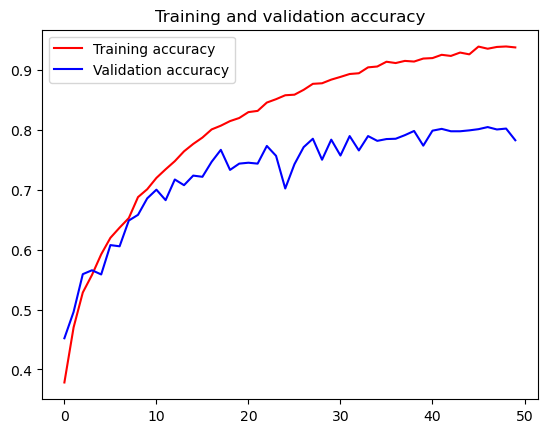

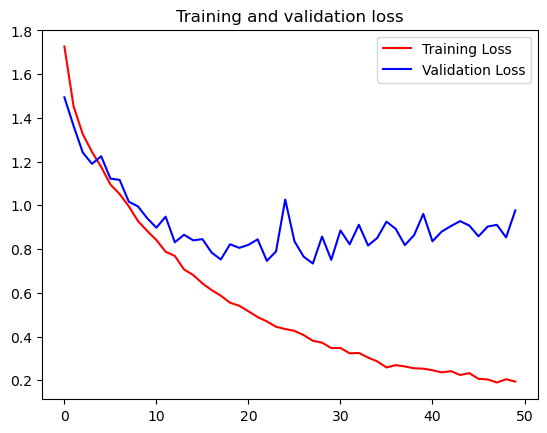

50/50 [==============================] - 1s 17ms/step

---Test case---
Prediction: hiphop
 Fact: disco



In [ ]:

preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

inputs, targets = load_data(json_path=JSON_PATH)

Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

input_shape = (Xtrain.shape[1], Xtrain.shape[2])
model = design_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics = ['acc'])

model.summary()

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=50, batch_size=32)

plot_performance(history)

make_prediction(model, Xtest, ytest, 24)
